In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#Random f(x)
def f(x):
    return 3*x**2 -2*x -1

In [7]:
f(2)

7

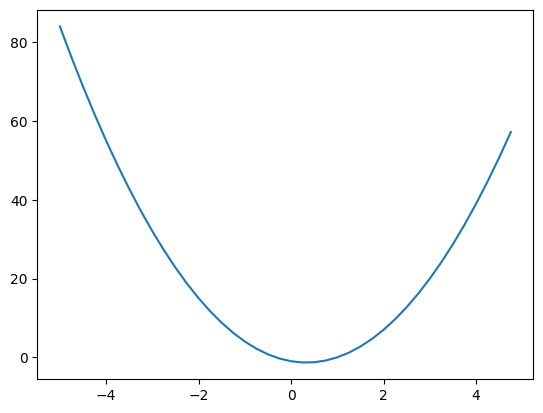

In [8]:
#Plot f(x)
xs = np.arange(-5, 5, 0.25)
plt.plot(xs, f(xs))

Derivative = Slope

$f'(a) = \lim_{h \to 0} \frac{f(a + h) - f(a)}{h}$.

In [ ]:
h = 0.000001
x = 2/6

(f(x + h) - f(x))/h

3.000044657142098e-06

In [ ]:
# More complex function
# 3 inputs
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


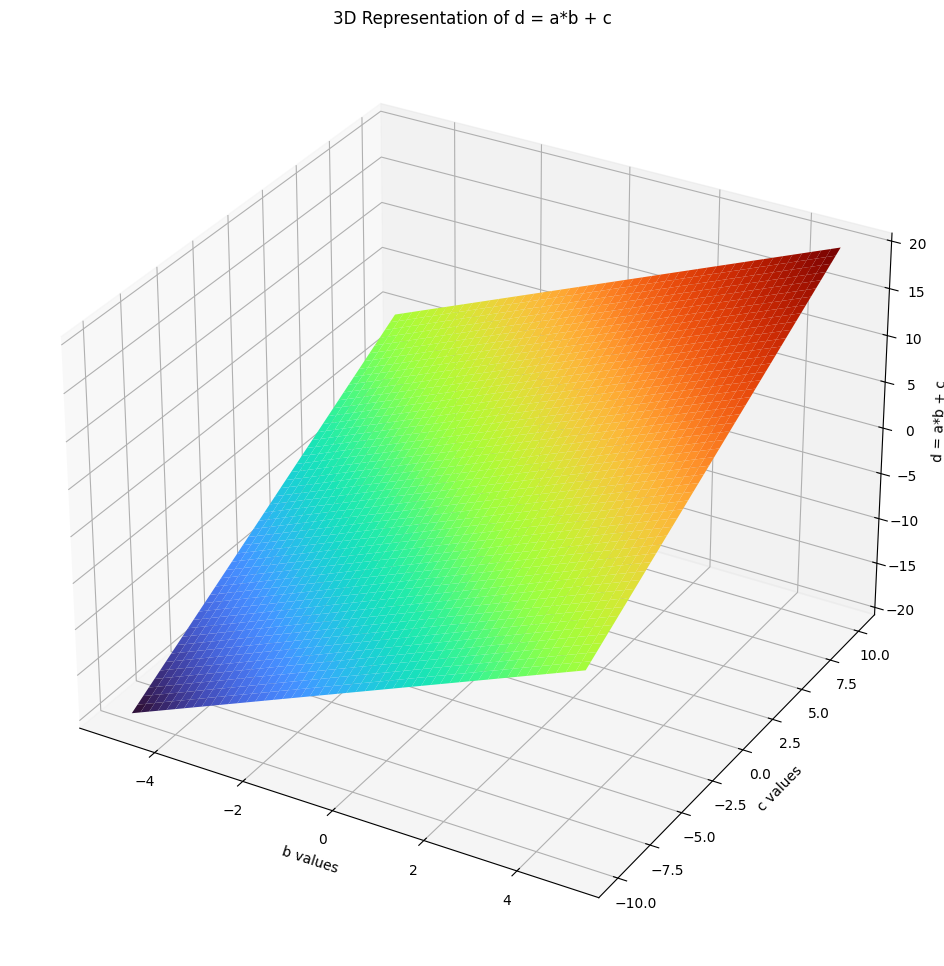

In [ ]:
# 3D representing
from mpl_toolkits.mplot3d import Axes3D

# Define the range of values for b and c
b_values = np.linspace(-5, 5, 50)  # Varying b
c_values = np.linspace(-10, 10, 50)  # Varying c
B, C = np.meshgrid(b_values, c_values)

# Define a fixed value for a
a = 2.0

# Compute d = a * b + c
D = a * B + C

# Create the 3D plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(B, C, D, cmap='turbo', edgecolor='none')

# Labels
ax.set_xlabel('b values')
ax.set_ylabel('c values')
ax.set_zlabel('d = a*b + c')
ax.set_title('3D Representation of d = a*b + c')

plt.show()

In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [27]:
#Lets build micrograd

class Value:
    """
    A class that tracks a value and its gradient for automatic differentiation.
    This is a scalar-valued node in our computation graph.
    """
    
    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initialize a Value node in the computation graph.
        
        Args:
            data: The actual value being tracked
            _children: Other Value objects that were used to create this one
            _op: The operation that produced this value (for visualization)
            label: Optional label for debugging
        """
        self.data = data                # The actual value being tracked
        
        self.grad = 0.0                 # Gradient of the final output with respect to this value
        self._backward = lambda: None   # Function to compute this node's gradient contribution. By default does nothing
        
        self._prev = set(_children)     # Set of Value objects that were used to create this one
        self._op = _op                  # The operation that created this Value ('+', '*', etc.)
        
        self.label = label              # Optional label for debugging

    def __repr__(self):
        """
        Provides nicer string representation of the Value object
        The thing it shows when you print()
        """
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        """
        Addition operation between two Value objects.
        Implements the chain rule for backpropagation.

        In Python, + --> __add__()
        """
        
        out = Value(self.data + other.data, (self, other), '+')
        #           (data, children, op)

        def _backward():
            # During backprop, add the gradient of the output to both inputs
            # ∂(a+b)/∂a = 1.0 and ∂(a+b)/∂b = 1.0
            #🚗 travels 3 times as fast as 🚲. 🚲 travels 4 times as fast as 🚶‍♂️. 🚗 = 3 × 4 = 12 times as fast as 🚶‍♂️
            self.grad += 1.0 * out.grad    # Chain rule: local gradient * upstream gradient
            other.grad += 1.0 * out.grad
            print("backward: "+self.label)
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        """
        Multiplication operation between two Value objects.
        Implements the chain rule for backpropagation.

        In Python, * --> __mul__()
        """
        out = Value(self.data * other.data, (self, other), '*')
                #           (data, children, op)

        
        def _backward():
            # During backprop, add the weighted gradients
            # ∂(a*b)/∂a = b and ∂(a*b)/∂b = a
            self.grad += other.data * out.grad   # Chain rule: local gradient * upstream gradient
            other.grad += self.data * out.grad
            print("backward: "+self.label)

        out._backward = _backward
        
        return out
    
    def tanh(self):
        """
        Hyperbolic tangent activation function.
        Implements the chain rule for backpropagation.
        """
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            # Derivative of tanh(x) is 1 - tanh²(x)
            self.grad += (1 - t**2) * out.grad   # Chain rule: local gradient * upstream gradient
            print("backward: "+self.label)
        out._backward = _backward
        
        return out
    
    def backward(self):
        """
        Runs backpropagation to compute gradients of all nodes in the graph.
        Uses topological sort to process nodes in the correct order.
        """
        
        # Build topological ordering of all nodes in the graph
        topo = []
        visited = set()
        def build_topo(v):
            """Recursive helper function to build topological ordering"""
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        # Go through the nodes in reverse order
        self.grad = 1.0    # Initialize output gradient as 1.0
        for node in reversed(topo):
            node._backward()    # Compute gradient contributions



In [ ]:
from graphviz import Digraph
#https://graphviz.org/

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

## Example #1. Manual backprop on simple expression

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

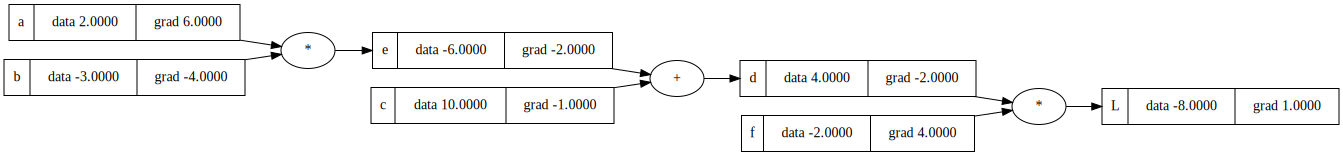

In [ ]:
L.grad=1.0


d.grad=-2 #∂L/∂d=f since L=d*f
f.grad=4 #∂L/∂f=d since L=d*f

c.grad=-1 #∂L/∂c-> ∂L/∂c=∂L/∂d*∂d/∂c
e.grad=-2 #∂L/∂e

b.grad=-4 #∂L/∂b
a.grad=6 #∂L/∂a

draw_dot(L)

## Example #2. Backprop a neuron

<img src="neuron_model.jpeg" width="600">

* Inputs (x₀, x₁, x₂) come in through "axons"
* Each input is multiplied by a "weight" (w₀, w₁, w₂) at the synapse connections
* All these weighted inputs are summed up (Σwixi) and a bias (b) is added
* This sum goes through an "activation function" (f) that determines the neuron's output. Usually a squashing function
* The result is sent out through the output axon

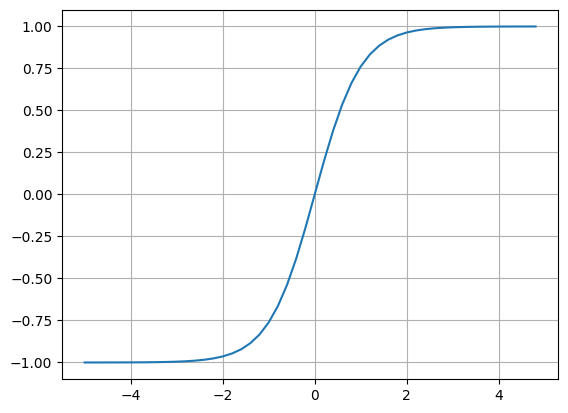

In [20]:
#tanh

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [21]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')#6.88136... to obtain fancy numbers in the backprop
#Σwixi +b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

### Manually calculated grads

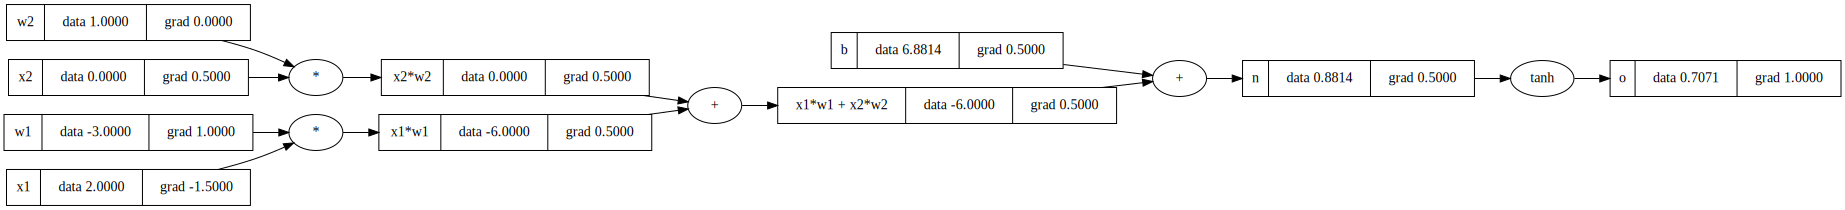

In [26]:

o.grad=1.0

#Manually calculated
n.grad=0.5

b.grad=0.5
x1w1x2w2.grad=0.5

x1w1.grad=0.5
x2w2.grad=0.5

x1.grad=-1.5
w1.grad=1
x2.grad=0.5
w2.grad=0

draw_dot(o)


### Calculating grads with each backward function

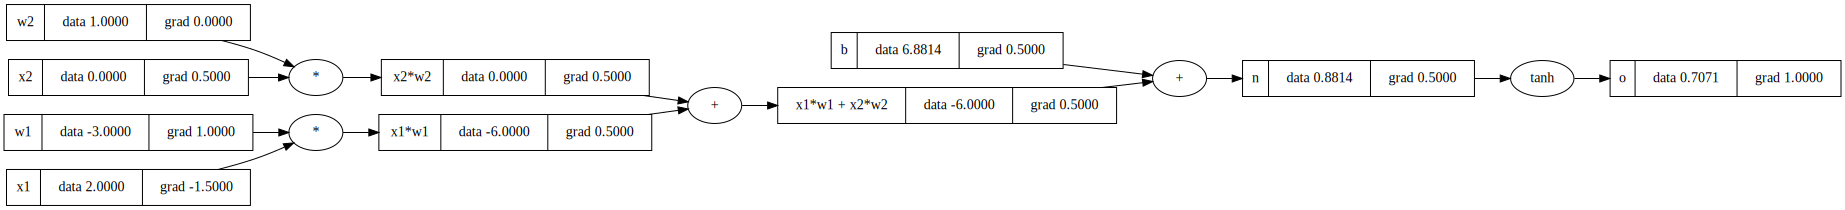

In [31]:


#Reset
def reset_grads():
    o.grad=1.0
    n.grad=0
    b.grad=0
    x1w1x2w2.grad=0
    x1w1.grad=0
    x2w2.grad=0
    x1.grad=0
    w1.grad=0
    x2.grad=0
    w2.grad=0

reset_grads()

o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)


### Building topological sort and applying back to all nodes

In [30]:
topo = []        # Stores nodes in topologically sorted order
visited = set()  # Visited nodes

def build_topo(v):
    # If we haven't seen this node before...
    if v not in visited:
        # Mark it as visited 
        visited.add(v)
        
        # First, recursively visits all prevs nodes
        for child in v._prev:
            build_topo(child)
            
        # After all prerequisites are processed, add current node
        topo.append(v)

build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

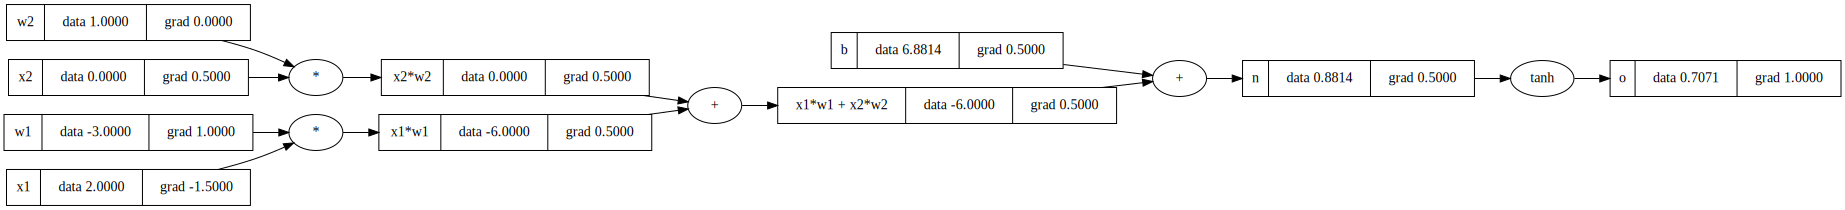

In [32]:
#Reset grads
reset_grads()

#Build topo
topo = []       
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)


for node in reversed(topo):
    node._backward()

draw_dot(o)

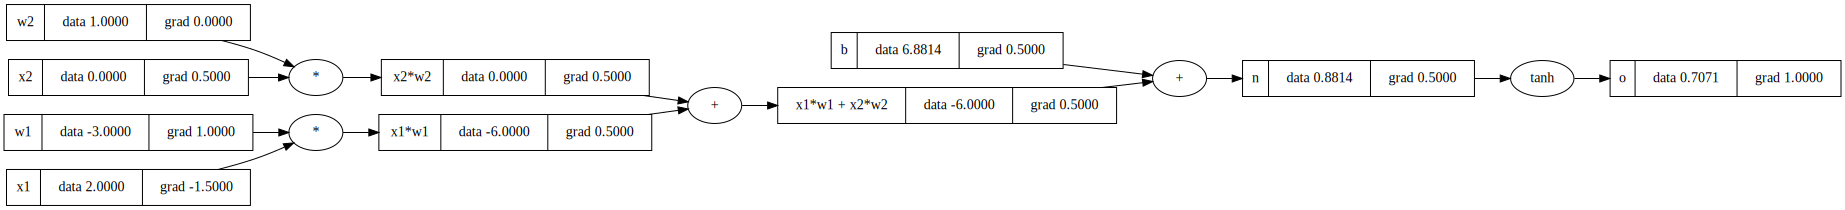

In [ ]:
#Or, in a more elegant way... (creating function backward)

#Reset grads
reset_grads()

o.backward()

draw_dot(o)


## Bug when reusing the same variable

Note that orginally gradients were overwritten. Instead, they need to be acumulated

Thats way in every
```python
def _backward():
```
we do
```python
 self.grad +=
 ```
and NOT
```python
 self.grad =
 ```


backward: d
backward: a
backward: a


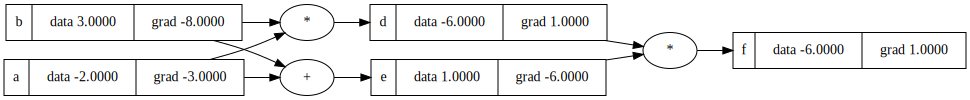

In [38]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)